In [10]:
import logging

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings
import os

# Squash warning messages for cleaner output in the notebook
warnings.showwarning = lambda *args, **kwargs: None

import azureml.core
from azureml.core import Experiment, Workspace, Dataset
from azureml.train.automl import AutoMLConfig
from datetime import datetime

In [11]:
ws = Workspace.from_config()

# choose a name for experiment
experiment_name = 'oil_prediction'

experiment=Experiment(ws, experiment_name)

print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

run = experiment.start_logging()

Workspace name: knowledge-session
Azure region: eastus2
Subscription id: cdb9c206-0977-4fc2-9190-23ed6c7c7063
Resource group: Stanbic


In [12]:
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'oil_prediction'

# # project folder
# project_folder = './sample_projects/automl-forecasting-energy-demand'

experiment = Experiment(ws, experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Subscription ID,cdb9c206-0977-4fc2-9190-23ed6c7c7063
Workspace,knowledge-session
Resource Group,Stanbic
Location,eastus2
Run History Name,oil_prediction


In [13]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your cluster.
amlcompute_cluster_name = 'forecast-compute'

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_DS12_V2',
                                                           max_nodes=6)
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.

Running


In [14]:
target_column_name = 'MonthlyOil (bbl)'
time_column_name = 'Date'

In [17]:
dataset = Dataset.Tabular.from_delimited_files(path = "https://github.com/ChidiNdego/final-year-project/raw/main/oil_data.csv").with_timestamp_columns(fine_grain_timestamp=time_column_name) 
dataset.take(5).to_pandas_dataframe().drop(columns='Column1').reset_index(drop=True)

,Date,MonthlyOil (bbl),MonthlyGAS (scf),MonthlyWATER (bbl)
0,1973-11-30,152613.87,19988290.00,396.27
1,1973-12-31,125818.61,15362025.00,1492.28
2,1974-01-31,124302.96,18116595.00,2632.49
3,1974-02-28,125497.97,18257855.00,5378.16
4,1974-03-31,142682.13,20376755.00,4597.57


In [21]:
train = dataset.time_before(datetime(1987, 1, 1), include_boundary=True)
train.to_pandas_dataframe().drop(columns='Column1').reset_index(drop=True).sort_values(time_column_name).tail(5)

,Date,MonthlyOil (bbl),MonthlyGAS (scf),MonthlyWATER (bbl)
153,1986-08-31,97268.56,12854660.00,268884.92
154,1986-09-30,66145.64,7804615.00,193260.25
155,1986-10-31,64906.51,9676310.00,131052.15
156,1986-11-30,42847.48,7486780.00,65214.72
157,1986-12-31,33318.13,4732210.00,58905.85


In [23]:
# split into test based on time
test = dataset.time_between(datetime(1987, 2, 1), datetime(1994, 4, 1))
test.to_pandas_dataframe().drop(columns='Column1').reset_index(drop=True).head(5)

,Date,MonthlyOil (bbl),MonthlyGAS (scf),MonthlyWATER (bbl)
0,1987-02-28,30619.72,3849335.00,58163.63
1,1987-03-31,49112.32,6745165.00,176969.15
2,1987-04-30,47590.14,3143035.00,103627.75
3,1987-05-31,65340.52,8864065.00,141367.75
4,1987-06-30,82921.07,4273115.00,214400.94


In [24]:
forecast_horizon = 24

In [25]:
from azureml.automl.core.forecasting_parameters import ForecastingParameters
forecasting_parameters = ForecastingParameters(
    time_column_name=time_column_name,
    forecast_horizon=forecast_horizon,
    freq='D', # Set the forecast frequency to be hourly
    short_series_handling = True
)

automl_config = AutoMLConfig(task='forecasting',                             
                             primary_metric='normalized_root_mean_squared_error',
                             #blocked_models = ['ExtremeRandomTrees', 'AutoArima', 'Prophet'],                             
                             experiment_timeout_hours=0.3,
                             training_data=train,
                             label_column_name=target_column_name,
                             compute_target=compute_target,
                             enable_early_stopping=True,
                             n_cross_validations=3,                             
                             verbosity=logging.INFO,
                             forecasting_parameters=forecasting_parameters)

In [26]:
remote_run = experiment.submit(automl_config, show_output=True)

Submitting remote run.
No run_configuration provided, running on forecast-compute with default configuration
Running on remote compute: forecast-compute


Experiment,Id,Type,Status,Details Page,Docs Page
oil_prediction,AutoML_6bacc556-4f44-4c9c-bce2-22e37f1d21f5,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation



Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Short series handling
STATUS:       PASSED
DESCRIPTION:  Automated ML detected enough data points for each series in the input data to continue with training.
              

****************************************************************************************************

TYPE:         Frequency detection
STATUS:       PASSED
DESCRIPTION:  The time series was analyzed, all data points are aligned with detected frequency.
              

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about

In [27]:
remote_run.wait_for_completion()

{'runId': 'AutoML_6bacc556-4f44-4c9c-bce2-22e37f1d21f5',
 'target': 'forecast-compute',
 'status': 'Completed',
 'startTimeUtc': '2021-07-10T22:08:46.800308Z',
 'endTimeUtc': '2021-07-10T22:32:42.180607Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_root_mean_squared_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '3',
  'target': 'forecast-compute',
  'AMLSettingsJsonString': '{"path":null,"name":"oil_prediction","subscription_id":"cdb9c206-0977-4fc2-9190-23ed6c7c7063","resource_group":"Stanbic","workspace_name":"knowledge-session","region":"eastus2","compute_target":"forecast-compute","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":false,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation":false,"iterations":1000,"primary_metric

In [28]:
best_run, fitted_model = remote_run.get_output()
fitted_model.steps

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


[('timeseriestransformer',
  TimeSeriesTransformer(
      pipeline_type=TimeSeriesPipelineType.FULL,
      max_horizon=24,
      use_stl=None,
      seasonality=7,
      force_time_index_features=None,
      grain_column_names=['_automl_dummy_grain_col'],
      drop_column_names=[],
      origin_time_colname='origin',
      group=None,
      country_or_region=None,
      freq='D',
      time_column_name='Date',
      pipeline=Pipeline(
          memory=None,
          steps=[('make_numeric_na_dummies', MissingDummiesTransformer(
              numerical_columns=['Column1', 'MonthlyGAS (scf)', 'MonthlyWATER (bbl)']
          )), ('impute_na_numeric_datetime', TimeSeriesImputer(
              end=None,
              freq='D',
              impute_by_horizon=False,
              input_column=['Column1', 'MonthlyGAS (scf)', 'MonthlyWATER (bbl)'],
              limit=None,
              limit_direction='forward',
              method=OrderedDict([('ffill', [])]),
              option='fillna

In [29]:
fitted_model.named_steps['timeseriestransformer'].get_engineered_feature_names()

['Column1',
 'MonthlyGAS (scf)',
 'MonthlyWATER (bbl)',
 '_automl_target_col_WASNULL',
 'Column1_WASNULL',
 'MonthlyGAS (scf)_WASNULL',
 'MonthlyWATER (bbl)_WASNULL',
 '_automl_year',
 '_automl_half',
 '_automl_quarter',
 '_automl_month',
 '_automl_day',
 '_automl_wday',
 '_automl_qday',
 '_automl_week']

In [30]:
# Get the featurization summary as a list of JSON
featurization_summary = fitted_model.named_steps['timeseriestransformer'].get_featurization_summary()
# View the featurization summary as a pandas dataframe
pd.DataFrame.from_records(featurization_summary)

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,Column1,Numeric,No,2,"[MedianImputer, ImputationMarker]"
1,MonthlyGAS (scf),Numeric,No,2,"[MedianImputer, ImputationMarker]"
2,MonthlyWATER (bbl),Numeric,No,2,"[MedianImputer, ImputationMarker]"
3,_automl_target_col,Numeric,No,1,[ImputationMarker]
4,Date,DateTime,No,8,[DateTimeTransformer]


In [31]:
#Forecasting

test_experiment = Experiment(ws, experiment_name + "_inference")

In [35]:
X_test = test.to_pandas_dataframe().reset_index(drop=True)
y_test = X_test.pop(target_column_name).values

In [36]:
# The featurized data, aligned to y, will also be returned.
# This contains the assumptions that were made in the forecast
# and helps align the forecast to the original data
y_predictions, X_trans = fitted_model.forecast(X_test)

In [45]:
# from run_forecast import run_remote_inference
# remote_run_infer = run_remote_inference(test_experiment=test_experiment,
#                                         compute_target=compute_target,
#                                         train_run=best_run,
#                                         test_dataset=test,
#                                         target_column_name=target_column_name)
# remote_run_infer.wait_for_completion(show_output=False)

# # download the inference output file to the local machine
# remote_run_infer.download_file('outputs/predictions.csv', 'predictions.csv')

In [46]:
# from forecasting_script.py import align_outputs

# df_all = align_outputs(y_predictions, X_trans, X_test, y_test, target_column_name)

[Test data scores]

explained_variance:   0.108
mean_absolute_percentage_error:   89.967
median_absolute_error:   35989.671
normalized_median_absolute_error:   0.198
mean_absolute_error:   34938.764
normalized_root_mean_squared_error:   0.219
r2_score:   -0.427
root_mean_squared_error:   39909.947
normalized_root_mean_squared_log_error:   0.156
spearman_correlation:   0.273
normalized_mean_absolute_error:   0.192
root_mean_squared_log_error:   1.895


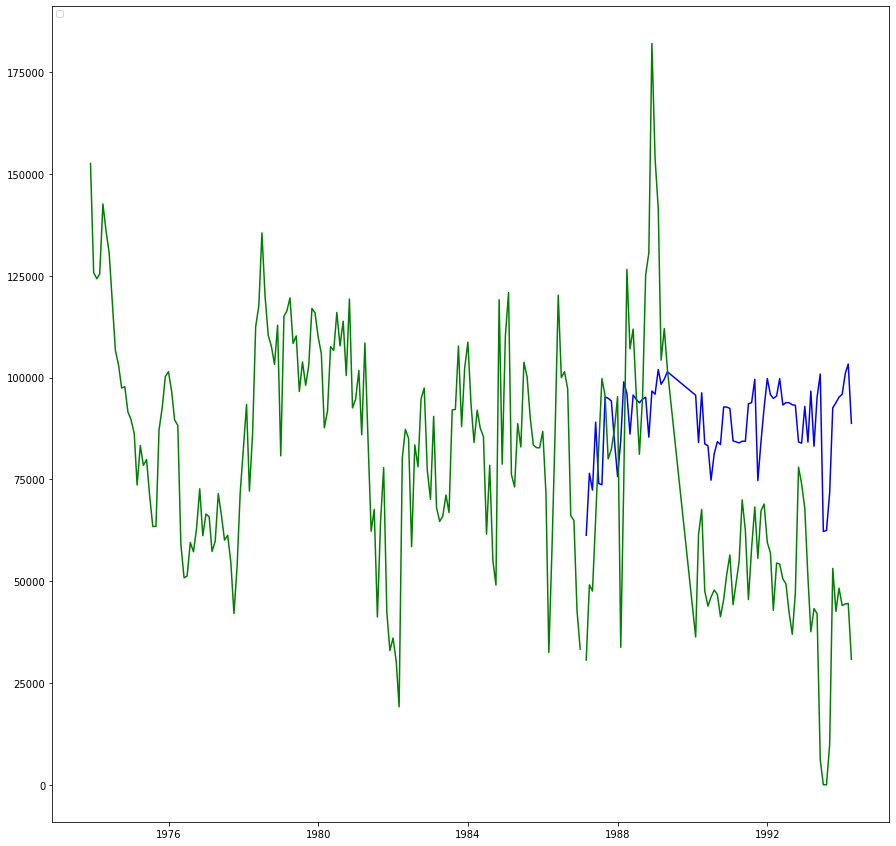

In [69]:
from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring
from matplotlib import pyplot as plt

# use automl metrics module
scores = scoring.score_regression(
    y_test=y_test,
    y_pred=y_predictions,
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET))

print("[Test data scores]\n")
for key, value in scores.items():    
    print('{}:   {:.3f}'.format(key, value))
    
# Plot outputs
%matplotlib inline
plt.figure(figsize=(15, 15))
train_dat =plt.plot(train.to_pandas_dataframe()['Date'], train.to_pandas_dataframe()['MonthlyOil (bbl)'], color='g')
test_pred = plt.plot(test.to_pandas_dataframe()['Date'], y_predictions, color='b')
#test_pred = plt.plot(y_test, y_predictions, color='b')
test_test = plt.plot(test.to_pandas_dataframe()['Date'], y_test, color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

In [57]:
len(y_predictions)

77

In [63]:
len(test.to_pandas_dataframe()['Date'])

77